# Automatic Apparent Age Estimation (TASK 1)

*   Authors: Salma OUARDI / NI WANG / Mohammad Ali Jauhar
*   Emails: salma.ouardi@universite-paris-saclay.fr / mohammad-ali.jauhar@universite-paris-saclay.fr / niwang.fr@gmail.com 


*   Codalab usernames: sallyxhope / Mohammad.a / Ni_Wang









## **I - Introduction**
In This task we will try to solve the fairness and bias problem in the APPA-REAL dataset.
First we will work on the Data Augmentation stategy to solve the problem. Second, we'll focus on the Custom Loss strategy without data augmentation.

### **1. The setup**
We need to install some packages and import some libraries.

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Check the Tensorflow version
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data_with-no-test-labels.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_with-no-test-labels.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data.zip

--2022-10-08 18:31:24--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data_with-no-test-labels.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 803085698 (766M) [application/zip]
Saving to: ‘app_data_with-no-test-labels.zip’

app_data_with-no-te 100%[===================>] 765.88M  17.4MB/s    in 60s     

2022-10-08 18:32:24 (12.9 MB/s) - ‘app_data_with-no-test-labels.zip’ saved [803085698/803085698]

Data decompressed successfully
rm: cannot remove 'app_data.zip': No such file or directory


In [ ]:
import numpy as np

# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data (images only) to be used later in our challenge
X_test = np.load('./data/data_test.npy')


# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate 
                      # them using the raw data, i.e., the apparent age values

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)


### **3. Defining the model**

NASNet refers to Neural Architecture Search Network, a family of models that were designed automatically by learning the model architectures directly on the dataset of interest.

Here we consider NASNet-A, the highest performance model that was found for the CIFAR-10 dataset, and then extended to ImageNet 2012 dataset, obtaining state of the art performance on CIFAR-10 and ImageNet 2012. 

In [ ]:
!pip install image-classifiers==1.0.0b1
!pip install keras_applications
import keras_applications
%env CM_FRAMEWORK=tf.keras
from classification_models.tfkeras import Classifiers

NasNet, preprocess_input = Classifiers.get('nasnetmobile')

#Prepare our images
X_train_processed=preprocess_input(np.copy(X_train))
X_valid_processed=preprocess_input(np.copy(X_valid))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-py3-none-any.whl size=19970 sha256=c6c6bc9b2c234e87a9c83b6a48639eabfcd4a258043eb23bebfb8504242640f7
  Stored in directory: /root/.cache/pip/wheels/62/1d/1d/d551ddb7ef02acac3373cb39ccd101661f28635a0d91febb69
Successfully built image-classifiers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.4 MB/s 
env: CM_FRAMEWORK=tf.keras


In [ ]:
# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# build model
base_model =NasNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

20004864/19993432 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
history = model.fit(X_train_processed, Y_train, validation_data=(X_valid_processed, Y_valid), batch_size=96, epochs=100, shuffle=True, verbose=1, callbacks=[es])

Epoch 1/100
32/32 [==============================] - 88s 2s/step - loss: 0.0218 - mae: 0.1128 - val_loss: 0.0279 - val_mae: 0.1361
Epoch 2/100
32/32 [==============================] - 49s 2s/step - loss: 0.0061 - mae: 0.0610 - val_loss: 0.0315 - val_mae: 0.1476
Epoch 3/100
32/32 [==============================] - 49s 2s/step - loss: 0.0028 - mae: 0.0419 - val_loss: 0.0287 - val_mae: 0.1397
Epoch 4/100
32/32 [==============================] - 49s 2s/step - loss: 0.0015 - mae: 0.0309 - val_loss: 0.0285 - val_mae: 0.1396
Epoch 5/100
32/32 [==============================] - 47s 1s/step - loss: 9.9569e-04 - mae: 0.0247 - val_loss: 0.0275 - val_mae: 0.1365
Epoch 6/100
32/32 [==============================] - 47s 1s/step - loss: 9.7787e-04 - mae: 0.0246 - val_loss: 0.0283 - val_mae: 0.1389
Epoch 7/100
32/32 [==============================] - 47s 1s/step - loss: 0.0010 - mae: 0.0246 - val_loss: 0.0289 - val_mae: 0.1405
Epoch 8/100
32/32 [==============================] - 49s 2s/step - loss: 8.

KeyboardInterrupt: ignored

## **II - Strategy 1: Data Augmentation**

### **1- First Approach: using Albumentations which is a fast and flexible image augmentation library**

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install albumentations==1.1.0
import albumentations as A
import tensorflow as tf
AUGMENTATIONS_TRAIN =A.Compose([
                                A.OneOf([
                                         A.ShiftScaleRotate (p=.8),
                                         A.ElasticTransform (p=.8),
                                         A.OpticalDistortion(p=.8),
                                         A.GridDistortion   (p=.8)
                                         ]),
                                A.RandomGamma(p=.66),
                                A.HorizontalFlip(p=.5),
                                A.Blur(p=0.3),
                                A.Cutout(p=0.2),
                                A.GaussNoise(p=0.3)
                                ])

AUGMENTATIONS_TEST = A.Compose([
                                # A.ToFloat(max_value=255)
                                A.NoOp()
                                ])
from tensorflow.keras.utils import Sequence
class XSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def getitem(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        img_orig=[]
        img=[]
        specific_augmenting=False
        for i in range(batch_x.shape[0]):
            if specific_augmenting and batch_y[i]*100>60 : #Augmenting only the age >60 
                img_orig.append(batch_x[i])
                agm = self.augment(image=batch_x[i])
                img.append(agm["image"])
            if not specific_augmenting:
                img_orig.append(batch_x[i])
                agm = self.augment(image=batch_x[i])
                img.append(agm["image"])              
        img=np.array(img)
        img_orig=np.array(img_orig)
        img=preprocess_input(img)
        return img.astype("float32"),batch_y.astype("float32")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 9.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [ ]:
# Fit the model on the batches generated by datagen.flow().
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
history= model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=[es])

Epoch 1/50
64/64 [==============================] - 80s 895ms/step - loss: 0.0015 - mae: 0.0277 - val_loss: 0.0237 - val_mae: 0.1173
Epoch 2/50
64/64 [==============================] - 51s 793ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0230 - val_mae: 0.1153
Epoch 3/50
64/64 [==============================] - 52s 796ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0227 - val_mae: 0.1150
Epoch 4/50
64/64 [==============================] - 52s 788ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0224 - val_mae: 0.1137
Epoch 5/50
64/64 [==============================] - 52s 795ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 0.0215 - val_mae: 0.1112
Epoch 6/50
64/64 [==============================] - 52s 788ms/step - loss: 0.0010 - mae: 0.0224 - val_loss: 0.0215 - val_mae: 0.1121
Epoch 7/50
64/64 [==============================] - 51s 788ms/step - loss: 9.4312e-04 - mae: 0.0212 - val_loss: 0.0208 - val_mae: 0.1106
Epoch 8/50
64/64 [==============================] - 52s 783ms/ste

16/16 [==============================] - 3s 165ms/step
MAE (validation) = 6.78399992
-----


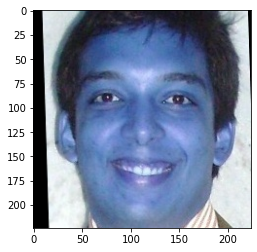

predicted age = 26.198 - Ground truth = 26.231


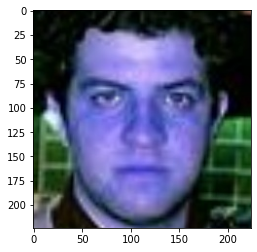

predicted age = 32.546 - Ground truth = 27.256


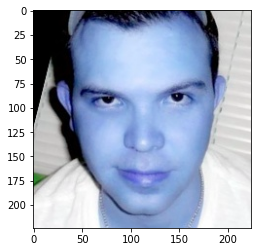

predicted age = 27.099 - Ground truth = 23.143


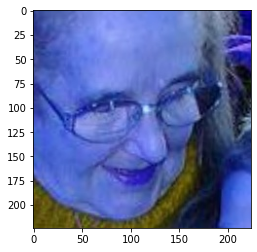

predicted age = 34.394 - Ground truth = 73.289


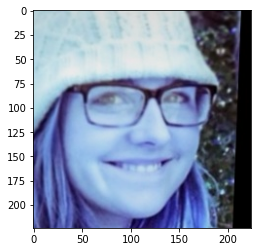

predicted age = 28.310 - Ground truth = 20.143


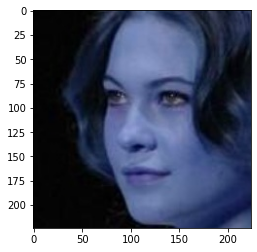

predicted age = 25.695 - Ground truth = 25.083


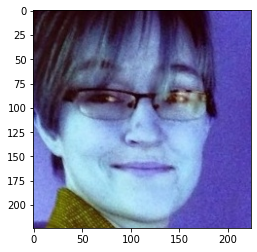

predicted age = 33.270 - Ground truth = 34.769


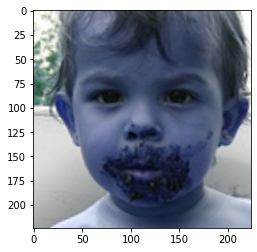

predicted age = 5.976 - Ground truth = 1.162


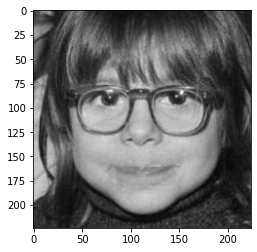

predicted age = 23.284 - Ground truth = 4.846


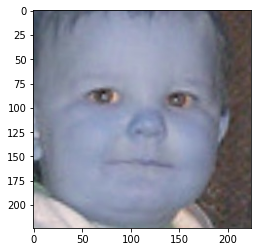

predicted age = 8.285 - Ground truth = 1.378


In [ ]:
predictions_st2_valid = model.predict(preprocess_input(np.copy(X_valid)), batch_size=96, verbose=1)
# re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
predictions_st2_valid_final = predictions_st2_valid*100
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_valid_final[i],Y_valid[i]*100)))

print('MAE (validation) = %.8f' %(np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print('-----')
for i in range(0,10):
  plt.figure()
  plt.imshow(cv2.cvtColor(X_valid[i], cv2.COLOR_BGR2RGB))
  plt.show()
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_valid_final[i], Y_valid[i]*100))

### **2- Second Approach: Doing random augmentations manually**

### Preprocessing the images

In [ ]:
# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf.keras.applications.resnet50.preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.resnet50.preprocess_input(x)  

# Downloading the ResNet50 model pre-trained on Faces
We are using ResNet50 pre-trained on Faces (source [here](https://github.com/ox-vgg/vgg_face2))

In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

--2022-10-05 19:50:26--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip’

model.zip           100%[===================>] 102.89M  5.58MB/s    in 21s     

2022-10-05 19:50:47 (5.00 MB/s) - ‘model.zip’ saved [107893665/107893665]

Model decompressed successfully


# Loading the pre-trained model
- You can see the data we have downloaded and structure of Colab by clicking on 'Files', on the left side (<--) of this interface.



In [ ]:
import h5py

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# print the model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['base_input[0][0]']             
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

# Adapting the model to our needs
- In summary, we will ignore the last layer 'classifier_low_dim' and will include a few other layers on top of our backbone. Here, we also define the activation function we are going to use as output of the last FC layer (Sigmoid, in the case). Again, **this notebook is expected to be used as starting-kit. For the deliverabels, avoid simply making minor changes to it. Instead, exploit your creativity as much as you can.**

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(fc_512)
fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and pringing the final model
model = tf.keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['base_input[0][0]']             
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

# Freezing the first layers to allow the fine-tuning of the last FC layers (only)
- Next, we set some layer to be trainable or not, and print if layers are set to trainable = True or False.


In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174: 
    layer.trainable = False
  else:
    layer.trainable = True
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input False
1 conv1/7x7_s2 False
2 conv1/7x7_s2/bn False
3 activation_1 False
4 max_pooling2d_1 False
5 conv2_1_1x1_reduce False
6 conv2_1_1x1_reduce/bn False
7 activation_2 False
8 conv2_1_3x3 False
9 conv2_1_3x3/bn False
10 activation_3 False
11 conv2_1_1x1_increase False
12 conv2_1_1x1_proj False
13 conv2_1_1x1_increase/bn False
14 conv2_1_1x1_proj/bn False
15 add_1 False
16 activation_4 False
17 conv2_2_1x1_reduce False
18 conv2_2_1x1_reduce/bn False
19 activation_5 False
20 conv2_2_3x3 False
21 conv2_2_3x3/bn False
22 activation_6 False
23 conv2_2_1x1_increase False
24 conv2_2_1x1_increase/bn False
25 add_2 False
26 activation_7 False
27 conv2_3_1x1_reduce False
28 conv2_3_1x1_reduce/bn False
29 activation_8 False
30 conv2_3_3x3 False
31 conv2_3_3x3/bn False
32 activation_9 False
33 conv2_3_1x1_increase False
34 conv2_3_1x1_increase/bn False
35 add_3 False
36 activation_10 False
37 conv3_1_1x1_reduce False
38 conv3_1_1x1_reduce/bn False
39 activation_11 False
40 conv3_1_3x3

# IMPORTANT: Mounting your google drive to save your results
- Colab gives you LIMITED GPU access. Thus, it may kill your process (of training) if you pass a limited amount of training hours. To allow you to save your model while training, you can mount your google drive, as detailed next. This way, if the process is killed, you can (in a new session) load your checkpoints (trained model, from your google drive) and, for example, continue training or make predictions with the model you obtained (even if trained for a few epochs).
- In the following examples, the **the beset model (based on validation loss) is saved in my google drive inside a "/temp/" directory. You will need to addapt this path to your case.** 
- To save time, and to allow you to quickly 'play' and run the notebook, we have pre-trained some models, which are loaded (or not) based on some boolean variables (later, you will need to change/adapt these codes to achive the goals of this course).

In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = False
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.

# Training the Model / or downloading a model already trained
- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST1 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST1 to False to perfom the training.
  - The code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 32, and the model will be trained for 50 epochs (if Colab allows it based to the time budget)
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.

- Note: in case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure. Recommendation: first train your model for a few epochs to avoid the need of resume training. This way, you will get used with the code and the general pipeline. Later, you can play with that.

In [ ]:
import pickle

# load a model and train history (defined and trained
# as below, trained for 38 epochs)
#--------------------------
LOAD_BEST_MODEL_ST1 = True # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  
else:
  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])
  
  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

--2022-10-05 19:51:03--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100009889 (95M) [application/zip]
Saving to: ‘best_model_st1.zip’

best_model_st1.zip  100%[===================>]  95.38M  13.1MB/s    in 9.3s    

2022-10-05 19:51:13 (10.3 MB/s) - ‘best_model_st1.zip’ saved [100009889/100009889]

Model decompressed successfully


# Visualizing the train history


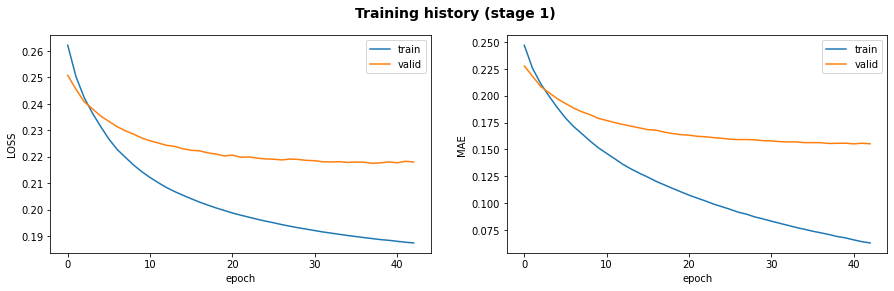

In [ ]:
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the 
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')  


# Loading the saved model and making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
#--------------------------
ENABLE_EVALUATION_ST1 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST1==True):
  saved_model = tf.keras.models.load_model('best_model.h5')
else:
  saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')

if(ENABLE_EVALUATION_ST1==True):
  # predict on the validation data (normalized outputs)
  predictions_st1_valid = saved_model.predict(X_valid, batch_size=32, verbose=1)

  # re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
  predictions_st1_valid_final = predictions_st1_valid*100

47/47 [==============================] - 15s 78ms/step


# Re-evaluating the model on the Validation set using the Mean Absolute Error (MAE) as metric (for debug purpose) and printing some predicted results.
- Note, as the train/validation labels were re-scaled to be in the range of [0,1] for training, the predictions will be in the same range [0,1]. Thus, we re-scale them back (to be in the range of "ages") in different sections of this notebook to facilitate the analysis, e.g., when printing output predictions or during evaluations.

In [ ]:
if(ENABLE_EVALUATION_ST1==True):
  # evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st1_valid_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

  # printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
  print('-----')
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st1_valid_final[i], Y_valid[i]*100))

MAE (validation) = 15.55821807
-----
predicted age = 32.366 - Ground truth = 26.231
predicted age = 10.629 - Ground truth = 27.256
predicted age = 12.281 - Ground truth = 23.143
predicted age = 39.238 - Ground truth = 73.289
predicted age = 1.911 - Ground truth = 20.143
predicted age = 36.458 - Ground truth = 25.083
predicted age = 4.866 - Ground truth = 34.769
predicted age = 0.427 - Ground truth = 1.162
predicted age = 5.832 - Ground truth = 4.846
predicted age = 0.030 - Ground truth = 1.378


---
---
# Performing a 2nd Stage of training, given the previously trained model, where all layers are set to "trainable"
- Up to here, we have just trained the last FC layers of our model. Now, we will load the model we have trained (referred to it as 1st stage), set all layers to TRAINABLE, and train the whole model. Training will take more time, but we expect to get better results.
- **Note that you are totally free to defien your own training strategy (e.g., using one single stage or multiple stages, freezing as many layers or blocks you want). Please, avoid simply reusing the starting-kit with minor changes, as your creativity will be considered during evaluation.**

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input True
1 conv1/7x7_s2 True
2 conv1/7x7_s2/bn True
3 activation_1 True
4 max_pooling2d_1 True
5 conv2_1_1x1_reduce True
6 conv2_1_1x1_reduce/bn True
7 activation_2 True
8 conv2_1_3x3 True
9 conv2_1_3x3/bn True
10 activation_3 True
11 conv2_1_1x1_increase True
12 conv2_1_1x1_proj True
13 conv2_1_1x1_increase/bn True
14 conv2_1_1x1_proj/bn True
15 add_1 True
16 activation_4 True
17 conv2_2_1x1_reduce True
18 conv2_2_1x1_reduce/bn True
19 activation_5 True
20 conv2_2_3x3 True
21 conv2_2_3x3/bn True
22 activation_6 True
23 conv2_2_1x1_increase True
24 conv2_2_1x1_increase/bn True
25 add_2 True
26 activation_7 True
27 conv2_3_1x1_reduce True
28 conv2_3_1x1_reduce/bn True
29 activation_8 True
30 conv2_3_3x3 True
31 conv2_3_3x3/bn True
32 activation_9 True
33 conv2_3_1x1_increase True
34 conv2_3_1x1_increase/bn True
35 add_3 True
36 activation_10 True
37 conv3_1_1x1_reduce True
38 conv3_1_1x1_reduce/bn True
39 activation_11 True
40 conv3_1_3x3 True
41 conv3_1_3x3/bn True
42 activati

# Training the whole model (2nd Stage of training)

- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST2 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST2 to False to perfom the training.
  - As before, the code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 16, and the model will be trained for 12 epochs (if Colab allows it based to the time budget). Note, if you increase the batch size too much, data may not fit the GPU capacity (as the number of parameters to train increased compared to the 1st stage). This is why we reduced it from 32 to 16.
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.
- WARNING: at this stage, training take more time, and colab may close before you finish training due to time constraints. Thus, you will need to define a good strategy! In case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure.
- WARNING: if you save your model and resume training, the train history will be lost. To monitore the training history, you may need to save the train history in another way (e.g., you can copy and paste the logs into a text file before resuming the training).

In [ ]:
# Loding a pretrained model or train
#--------------------------
LOAD_BEST_MODEL_ST2 = True
#--------------------------

if(LOAD_BEST_MODEL_ST2==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
  # decompressing the data
  with ZipFile('best_model_st2.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2.zip

else:
  
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



--2022-10-05 22:56:10--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271392330 (259M) [application/zip]
Saving to: ‘best_model_st2.zip’

best_model_st2.zip  100%[===================>] 258.82M  20.9MB/s    in 13s     

2022-10-05 22:56:24 (19.3 MB/s) - ‘best_model_st2.zip’ saved [271392330/271392330]

Model decompressed successfully


# Visualizing the Training history of both stages (1st stage and 2nd stage)
- Next, we show the train history of the models we have already trained for this course.
- The curves of both stages are concatenated. You can observe a peak close to epoch 42, which indicates the end of the first stage of training and the start of the 2nd stage, and how the 2nd stage improves the performance with respect to validation loss.

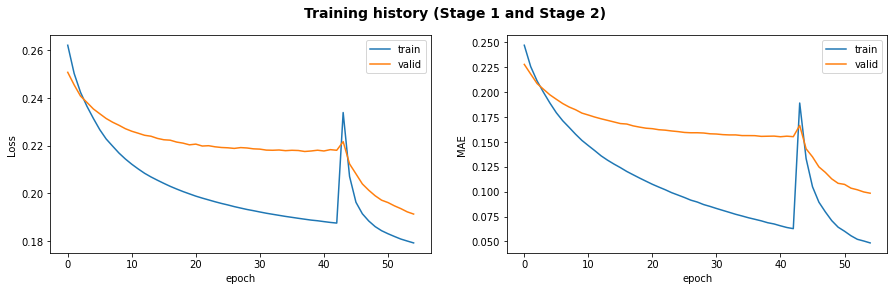

In [ ]:
if(LOAD_BEST_MODEL_ST1==True and LOAD_BEST_MODEL_ST2==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("train_history_2nd_stage.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# Re-evaluating the model lerned at the 2nd stage on the Validation set and printing some results
- Next, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained with the model trained at the 1st stage.

In [ ]:
#--------------------------
ENABLE_EVALUATION_ST2 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST2 == True):
  saved_model_2nd = tf.keras.models.load_model('best_model_2nd_stage.h5')
else:
  saved_model_2nd = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5')


if(ENABLE_EVALUATION_ST2==True):
  # predict on the validation data
  predictions_st2_valid = saved_model_2nd.predict(X_valid, batch_size=32, verbose=1)

  # re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
  predictions_st2_valid_final = predictions_st2_valid*100


47/47 [==============================] - 4s 71ms/step


In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # evaluating on test data (and re-scalling the labels back to the range of "ages")
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_valid_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

  # printing some predictions (in the range of "ages", 
  # after re-scaling the ground truth values back, using the normalization factor)
  print('-----')
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_valid_final[i], Y_valid[i]*100))

MAE (validation) = 9.84937392
-----
predicted age = 23.018 - Ground truth = 26.231
predicted age = 40.069 - Ground truth = 27.256
predicted age = 30.512 - Ground truth = 23.143
predicted age = 46.356 - Ground truth = 73.289
predicted age = 26.061 - Ground truth = 20.143
predicted age = 25.148 - Ground truth = 25.083
predicted age = 25.338 - Ground truth = 34.769
predicted age = 16.201 - Ground truth = 1.162
predicted age = 33.669 - Ground truth = 4.846
predicted age = 0.237 - Ground truth = 1.378


---
---
############### **Bias mitigation strategies** ###############
---
---
---

# Accuracy is not enough! We also need to evaluate how biased is our model!
- Next, we define different different functions, used to compute a bias score given different attributes.
  - Age bias
  - Gender bias
  - Ethnicity bias
  - Facial Expression bias
- In a nutshell, given a particular attribute, we compute the MAE for different groups. For the case of age, detailed next, we will have 4 groups base on different age ranges. We will have $MAE_1$, $MAE_2$, $MAE_3$ and $MAE_4$. Then, we compute the Absolute Difference among all. That is,
  - $D_{1,2} = |MAE_1-MAE_2|$
  - $D_{1,3} = |MAE_1-MAE_3|$
  - $D_{1,4} = |MAE_1-MAE_4|$
  - $D_{2,3} = |MAE_2-MAE_3|$
  - $D_{2,4} = |MAE_2-MAE_4|$
  - $D_{3,4} = |MAE_3-MAE_4|$

- The final score is obtained by the average of the absolute differentes. In the case of age:
  - $B_a = (D_{1,2} + D_{1,3} + D_{1,4} + D_{2,3} + D_{2,4} + D_{3,4})/6$

- To minimize your bias score, given a particular attribute, you will need to minimize the Absolute Difference among the different groups being evaluated.
- The big challenge here is to minimize **ALL** bias scores (i.e., age, gender, ethnicity and face expression).
- Next we define some auxiliary functions to evaluate different bias scores.

---
# Age Bias ($B_a$) 

- Evaluates how accurate the model is with respect to different age ranges.
  - group 1: age < 20
  - group 2: 20 <= age < 40
  - group 3: 40 <= age < 60
  - group 4: 60 <= age



In [ ]:
def age_bias(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))

  age_bias = (abs(np.mean(error_g1)-np.mean(error_g2)) +
            abs(np.mean(error_g1)-np.mean(error_g3)) +
            abs(np.mean(error_g1)-np.mean(error_g4)) +
            abs(np.mean(error_g2)-np.mean(error_g3)) +
            abs(np.mean(error_g2)-np.mean(error_g4)) +
            abs(np.mean(error_g3)-np.mean(error_g4)))/6

  print('---------')
  print('Age bias (Ba) = ', age_bias)

# Gender Bias ($B_g$) 
- Evaluates how accurate the model is with respect to different gender.
  - group 1: male
  - group 2: female


In [ ]:
def gender_bias(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  gender_bias = abs(np.mean(error_f)-np.mean(error_m))

  print('---------')
  print('Gender bias (Bg) = ', gender_bias)

# Ethnicity Bias ($B_e$)
- Evaluates how accurate the model is with respect to different ethnicity categories.
  - group 1: asian
  - group 2: afroamerican
  - group 3: caucasian


In [ ]:
def ethnicity_bias(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  
  ethnicity_bias = (abs(np.mean(error_as)-np.mean(error_af)) +
                   abs(np.mean(error_as)-np.mean(error_ca)) +
                   abs(np.mean(error_af)-np.mean(error_ca)))/3

  print('---------')
  print('Ethnicity bias (Be) = ', ethnicity_bias)

# Face expression bias ($B_f$)
- Evaluates how accurate the model is with respect to different face expression categories.
  - group 1: neutral
  - group 2: slightlyhappy
  - group 3: happy
  - group 4: other


In [ ]:
def face_expression_bias(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))

  face_bias = (abs(np.mean(error_h)-np.mean(error_s)) +
              abs(np.mean(error_h)-np.mean(error_n)) +
              abs(np.mean(error_h)-np.mean(error_o)) +
              abs(np.mean(error_s)-np.mean(error_n)) +
              abs(np.mean(error_s)-np.mean(error_o)) +
              abs(np.mean(error_n)-np.mean(error_o)))/6

  print('---------')
  print('Face Expression bias (Bf) = ', face_bias)




---
# Computing the Age, Gender and Ethnicity Biases on the Validation set
- Next, we compute the different bias scores **using the model we obtained after the 2nd stage of training**.
- We re-scale the predictions and labels back to the rage of "ages" using the normalization factor defined before, to make the analysis easier.

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2)
  age_bias(predictions_st2_valid_final,Y_valid*100)

  # computing the gender bias (model_stage_2)
  gender_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

  # computing the ethnicity bias (model_stage_2)
  ethnicity_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

  # computing the face bias (model_stage_2)
  face_expression_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

Age analysis:
Size group 1 = 305, MAE = 9.999447
Size group 2 = 841, MAE = 8.002159
Size group 3 = 275, MAE = 12.888004
Size group 4 = 61, MAE = 20.867609
---------
Age bias (Ba) =  6.914151509602864
Gender analysis:
Size group female = 716, MAE = 9.565139
Size group male = 766, MAE = 10.115055
---------
Gender bias (Bg) =  0.54991627
Ethnicity Analysis:
Size group asian = 116, MAE = 9.278401
Size group afroamerican = 50, MAE = 7.614076
Size group caucasian = 1316, MAE = 9.984631
---------
Ethnicity bias (Be) =  1.5803696314493816
Face experession Analysis:
Size group happy = 403, MAE = 9.681179
Size group slightlyhappy = 476, MAE = 9.799258
Size group neutral = 492, MAE = 9.735506
Size group other = 111, MAE = 11.179649
---------
Face Expression bias (Bf) =  0.7598605155944824


---
---
########### **Bias Mitigation (strategy 1)** ##############
---
---
---
# Strategies to improve Accuracy (i.e., to reduce the Error) and mitigate bias: 
- We will comment about two different strategies: 1) data augmentation and 2) custom loss with weighted samples.

# **1) Data augmentation**
- Next, we will augment the train set of people having age >= 60, as this group got the highest MAE compared to the other groups (regarding the age attribute only). 
- Different data augmentation strategies can be used. In this example, we  consider horizontal flip, changing the brighness, gaussian blur and translation.
- **Ideally, you should try to mitigate bias with respect to ALL categories and sub-groups**. 
- **Exploit your creativity as much as you can and avoid simply reusing or making minor changes of this starting-kit.**

In [ ]:
from tensorflow.keras import layers

# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')

# Randomly selecting a random image from train set
x = X_train[random.randint(0, len(X_train))]
print(x.shape)

(224, 224, 3)


In [ ]:
def colorjitter(img, cj_type="b"):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img

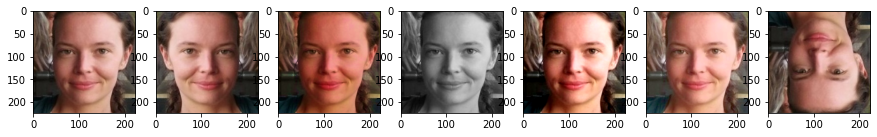

In [ ]:
# flip left right

x_flipped = cv2.flip(x,1)

#RGB to grayscale

x_grayscaled = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

#Random Contrast

x_contrasted = colorjitter(x, cj_type="c")

#Random brightness
x_bright = colorjitter(x, cj_type="b")

#flip up and down
x_up_down = cv2.flip(x,0)

#saturation
x_satur = colorjitter(x, cj_type="s")

# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(x_flipped, cv2.COLOR_BGR2RGB)) # random flip left right
ax3.imshow(cv2.cvtColor(x_satur, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(x_grayscaled, cv2.COLOR_BGR2RGB)) # to grayscale
ax5.imshow(cv2.cvtColor(x_contrasted, cv2.COLOR_BGR2RGB)) # change contrast
ax6.imshow(cv2.cvtColor(x_bright, cv2.COLOR_BGR2RGB)) #random brightness
ax7.imshow(cv2.cvtColor(x_up_down, cv2.COLOR_BGR2RGB)) #flip up down

# Applying the data augmentation described above
- Note, for each augmented image, we replicate its original label.

In [ ]:
# aux variables
X_train_augmented = []
Y_train_augmented = []

# loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):
  # check if image is in the group 'age >= 60'

  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    # flip left right
    X_train_augmented.append(cv2.flip(X_train[i],1))
    Y_train_augmented.append(Y_train[i])

    #saturation
    X_train_augmented.append(colorjitter(X_train[i], cj_type="s"))
    Y_train_augmented.append(Y_train[i])

    #change contrast
    X_train_augmented.append(colorjitter(X_train[i], cj_type="c"))
    Y_train_augmented.append(Y_train[i])

    # to grayscale
    #X_train_augmented.append(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY))
    #Y_train_augmented.append(Y_train[i]) 

    # flip up and down
    X_train_augmented.append(cv2.flip(X_train[i],0))
    Y_train_augmented.append(Y_train[i])
   
    # brightness
    X_train_augmented.append(colorjitter(X_train[i], cj_type="b"))
    Y_train_augmented.append(Y_train[i])
print(type(X_train_augmented))
print(type(X_train))
# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

Train set before augmentation =  (4065, 224, 224, 3)
<class 'list'>
<class 'numpy.ndarray'>
Train set after augmentation =  (4805, 224, 224, 3)


---
# **Training the 2nd stage again**, from the model obtained at the 1st stage, but now **using the augmented data**
- As before, we provide a model already trained (using the augmented data), which will be loaded as default if the code below is not changed. 
- You can change the boolean variable LOAD_BEST_MODEL_ST2_AUGMENTATION from True to False in order to train the model again, given your redefined strategy.

In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_AUGMENTATION = False
#--------------------------

if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2_aug.zip
  # decompressing the data
  with ZipFile('best_model_st2_aug.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2_aug.zip

else:
  # loading the saved model (best model learned at stage 1)
  saved_model = tf.keras.models.load_model('best_model.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])
  

Epoch 1/30
301/301 [==============================] - 67s 191ms/step - loss: 0.2400 - mae: 0.1973 - val_loss: 0.2263 - val_mae: 0.1756
Epoch 2/30
301/301 [==============================] - 56s 186ms/step - loss: 0.2094 - mae: 0.1397 - val_loss: 0.2124 - val_mae: 0.1448
Epoch 3/30
301/301 [==============================] - 56s 185ms/step - loss: 0.1983 - mae: 0.1110 - val_loss: 0.2077 - val_mae: 0.1328
Epoch 4/30
301/301 [==============================] - 56s 185ms/step - loss: 0.1924 - mae: 0.0940 - val_loss: 0.2040 - val_mae: 0.1239
Epoch 5/30
301/301 [==============================] - 56s 187ms/step - loss: 0.1894 - mae: 0.0833 - val_loss: 0.2009 - val_mae: 0.1168
Epoch 6/30
301/301 [==============================] - 56s 185ms/step - loss: 0.1867 - mae: 0.0749 - val_loss: 0.1994 - val_mae: 0.1144
Epoch 7/30
301/301 [==============================] - 56s 185ms/step - loss: 0.1852 - mae: 0.0696 - val_loss: 0.1967 - val_mae: 0.1081
Epoch 8/30
301/301 [==============================] - 5

# Train History of the provided pre-trained model

Epoch 1/12
292/292 [==============================] - 3358s 11s/step - loss: 0.2493 - mae: 0.2113 - val_loss: 0.2226 - val_mae: 0.1681

Epoch 2/12
292/292 [==============================] - 3390s 12s/step - loss: 0.2098 - mae: 0.1414 - val_loss: 0.2137 - val_mae: 0.1467

Epoch 3/12
292/292 [==============================] - 3310s 11s/step - loss: 0.1978 - mae: 0.1089 - val_loss: 0.2094 - val_mae: 0.1385

Epoch 4/12
292/292 [==============================] - 3284s 11s/step - loss: 0.1926 - mae: 0.0935 - val_loss: 0.2046 - val_mae: 0.1280

Epoch 5/12
292/292 [==============================] - 3142s 11s/step - loss: 0.1896 - mae: 0.0838 - val_loss: 0.2022 - val_mae: 0.1219

Epoch 6/12
292/292 [==============================] - 3072s 11s/step - loss: 0.1872 - mae: 0.0762 - val_loss: 0.1999 - val_mae: 0.1166

Epoch 7/12
292/292 [==============================] - 3006s 10s/step - loss: 0.1849 - mae: 0.0684 - val_loss: 0.1977 - val_mae: 0.1116

Epoch 8/12
292/292 [==============================] - 3029s 10s/step - loss: 0.1834 - mae: 0.0631 - val_loss: 0.1964 - val_mae: 0.1093

Epoch 9/12
292/292 [==============================] - 3043s 10s/step - loss: 0.1821 - mae: 0.0578 - val_loss: 0.1953 - val_mae: 0.1065

Epoch 10/12
292/292 [==============================] - 2591s 9s/step - loss: 0.1817 - mae: 0.0592 - val_loss: 0.1938 - val_mae: 0.1054

Epoch 11/12
292/292 [==============================] - 2541s 9s/step - loss: 0.1807 - mae: 0.0575 - val_loss: 0.1904 - val_mae: 0.0978

Epoch 12/12
292/292 [==============================] - 2421s 8s/step - loss: 0.1788 - mae: 0.0542 - val_loss: 0.1870 - val_mae: 0.0906

# Evaluating the model (with data augmentation) on the Validation set
- Here, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained by the previously trained models:
  - Model trained at the 1st stage: MAE = 16.98603930
  - Model trained at the 2nd stage (without data augmentation): MAE = 9.84937248
  - Model trained at the 2nd stage (with data augmentation): MAE = 9.05623911

In [ ]:
# loading the saved model
if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  saved_model_2nd_augm = tf.keras.models.load_model('best_model_2nd_stage_augmentation.h5')
else:
  saved_model_2nd_augm = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')


#--------------------------
ENABLE_EVALUATION_ST2_AUGMENTED = True
#--------------------------

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # predict on the test data
  predictions_st2_augmented = saved_model_2nd_augm.predict(X_valid, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st2_augmented_final = predictions_st2_augmented*100


47/47 [==============================] - 4s 76ms/step


In [ ]:
if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # evaluating on validation data
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_augmented_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

MAE (validation) = 7.66927417


# Computing the Age Bias (augmented data)
- Next, if we compare the age bias obtained by the two models (without/with) data augmentation, we can observed the model with augmented data was able to recude the age bias (from 6.914150238037109 to 5.179994901021321) on the Validation set. In particular, the MAE for group 4 reduced from 20.867607 to 17.510698, suggesting that our data augmentation had a positive impact in training.

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2) - previous model without data augmentation
  age_bias(predictions_st2_valid_final,Y_valid*100)

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):  
  # computing the age bias (model_stage_2) - with data augmentation
  age_bias(predictions_st2_augmented_final,Y_valid*100)

Age analysis:
Size group 1 = 305, MAE = 9.999447
Size group 2 = 841, MAE = 8.002159
Size group 3 = 275, MAE = 12.888004
Size group 4 = 61, MAE = 20.867609
---------
Age bias (Ba) =  6.914151509602864
Age analysis:
Size group 1 = 305, MAE = 9.106273
Size group 2 = 841, MAE = 6.154239
Size group 3 = 275, MAE = 9.363278
Size group 4 = 61, MAE = 13.734998
---------
Age bias (Ba) =  3.8332138061523438


---
---
########### **Bias Mitigation (strategy 2)** ##############
---
---
---
# Strategies to improve Accuracy (i.e., to reduce the Error):
# **2) Custom Loss:** sample weights to deal with inbalanced categories
- Next, we will created a "customized loss", which gives more weight to people having less samples in train data. For this simple example, **we will consider the age range only**. This way, we believe the model will be able to generalize a little bit better to those particular groups. Note that you are expect to build a more strong strategy, aiming to mitigate the bias with respect to all categories.

# Load the Train data again (to remove the augmented data) and generate the weigths 
- First, we will generate a weight for each age group (for g =1 to 4);
- The formula used to calculate the weight for each group $j$ is:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Where

    - $w_j$ is the weight for each group $j$,
    - $n_{samples}$ is the number of samples in the train set,
    - $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
    - $n_{samples,j}$ is the number of samples of class (group) $j$.


In [ ]:
def arith_mean(array):
  return np.sum(array) / len(array)

def geo_mean(array):
  return array.prod()**(1/len(array))

In [ ]:
def harm_mean(array):
  inverses = np.array([number**(-1) for number in array])
  return len(inverses) / inverses.sum()

In [ ]:
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100 # normalizing the age values to be between [0,1]

# preprocessing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# Counting the number of samples per gender group in the train data
males = females = 0
for i in range(0, M_train.shape[0]):
  if M_train[i][0] == 'male':
    males += 1
  else:
    females += 1

print('Gender group size = ', [males, females])
  
gender_weights = sum(np.array([males, females]))/(2*np.array([males, females]))
gender_weights = {'male': gender_weights[0],
                  'female': gender_weights[1]}

print('gender_weights per group = ', gender_weights)

# Counting the number of samples per ethinc group in the train data
caucasians = asians = afroamericans = 0

for i in range(0, M_train.shape[0]):
  if M_train[i][1] == 'caucasian':
    caucasians += 1
  elif M_train[i][1] == 'asian':
    asians += 1
  else:
    afroamericans += 1

print('Ethnicity group sizes ', [caucasians, asians, afroamericans])

ethnic_weights = sum(np.array([caucasians, asians, afroamericans])) / (3 * np.array([caucasians, asians, afroamericans]))
ethnic_weights = {'caucasian': ethnic_weights[0],
                  'asian': ethnic_weights[1],
                  'afroamerican': ethnic_weights[2]}

print('ethnic_weight per group = ', ethnic_weights)

# Counting the number of samples per facial expression
neutrals = slightlyhappys = happys = others = 0

for i in range(0, M_train.shape[0]):
  if M_train[i][2] == 'neutral':
    neutrals += 1
  elif M_train[i][2] == 'slightlyhappy':
    slightlyhappys += 1
  elif M_train[i][2] == 'happy':
    happys += 1
  else:
    others += 1

print('facial expressions group sizes ', [neutrals, slightlyhappys, happys, others])

facial_weights = sum(np.array([neutrals, slightlyhappys, happys, others])) / (4 * np.array([neutrals, slightlyhappys, happys, others]))
facial_weights = {'neutral': facial_weights[0],
                  'slightlyhappy': facial_weights[1],
                  'happy': facial_weights[2],
                  'other': facial_weights[3]}

print('facial_weight per group = ', facial_weights)



# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0,Y_train.shape[0]):
    gender, ethnic, fac = M_train[i][0], M_train[i][1], M_train[i][2]
    if(Y_train[i]*100<20):
      weights = np.array([w[0], gender_weights[gender], ethnic_weights[ethnic], facial_weights[fac]])
      mean = harm_mean(weights)
      sample_weights.append(mean)

    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      weights = np.array([w[1], gender_weights[gender], ethnic_weights[ethnic], facial_weights[fac]])
      mean = harm_mean(weights)
      sample_weights.append(mean)

    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      weights = np.array([w[2], gender_weights[gender], ethnic_weights[ethnic], facial_weights[fac]])
      mean = harm_mean(weights)
      sample_weights.append(mean)

    if(Y_train[i]*100>=60):
      weights = np.array([w[3], gender_weights[gender], ethnic_weights[ethnic], facial_weights[fac]])
      mean = harm_mean(weights)
      sample_weights.append(mean)

sample_weights = np.array(sample_weights)
sample_weights

group(s) size =  [796, 2389, 732, 148]
weights per group =  [1.27669598 0.42538719 1.38831967 6.86655405]
Gender group size =  [2068, 1997]
gender_weights per group =  {'male': 0.9828336557059961, 'female': 1.0177766649974962}
Ethnicity group sizes  [3522, 424, 119]
ethnic_weight per group =  {'caucasian': 0.3847245883021011, 'asian': 3.1957547169811322, 'afroamerican': 11.38655462184874}
facial expressions group sizes  [1404, 1784, 712, 165]
facial_weight per group =  {'neutral': 0.7238247863247863, 'slightlyhappy': 0.569646860986547, 'happy': 1.427317415730337, 'other': 6.159090909090909}


array([0.69185601, 0.54688551, 0.72954056, ..., 0.544286  , 0.544286  ,
       0.78962704])

# I) Using the SAMPLE WEIGHTS to train our model and,
- Next, you will see the code we used to train our model (2nd stage) from the model we obtained at the 1st stage, using the customized loss option with sample weights.
- As default, the code will load the model already trained. 
- You can change the boolean variable 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS' to False to train your model.
- Note, now we include other variables ('RESUME_TRAINING' and 'RESUME_FROM_EPOCH') to allow us resuming training, as well as to inform from what epoch we want to resume the trainind, detailed below.

# II) illustrating how to train + save + stop training + RESUME TRAINING
- **Imagine** you set 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False', 'NUM_EPOCHS = 12' and 'RESUME_TRAINING = False' to train your model the first time.
- Due to Colab limitations, your process stoped the training at the middle of epoch 10, and you saved the best model based on validation loss on epoch 9.
- In the above example, you can resume training from epoch 9 by setting the following parameters:
  - 'RESUME_TRAINING = True'
  - 'RESUME_FROM_EPOCH = 9'

- IMPORTANT: to resume training, you will need to monitor the epoch number where your model stopped before resuming the training, and change the defined variables properly. 
  - Note that the fit function is adapted to receive the sample weights ('sample_weight=sample_weights').
  - Also note that the fit function changes if you are training from epoch 0 (initial_epoch=0) or resume training (initial_epoch=RESUME_FROM_EPOCH). 
  - Finally, note that when you are resuming training, you load your 'best_model_2nd_stage_weighted.h5' instead of the model trained at stage 1 ('best_model.h5').


In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False
NUM_EPOCHS = 125
#--------------------------
RESUME_TRAINING = True
RESUME_FROM_EPOCH = 100
#--------------------------

if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_weighted.zip
  # decompressing the data
  with ZipFile('best_model_weighted.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_weighted.zip

else:
  # loading the saved model (best model learned at stage 1)
  if(RESUME_TRAINING == False):
    saved_model = tf.keras.models.load_model('best_model.h5') # load model from stage 1
  else:
    # resume training (stage 2)
    saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  #=================================================
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
  #=================================================

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

  if(RESUME_TRAINING == False):  
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  else:
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
  

Epoch 101/125
255/255 [==============================] - 54s 188ms/step - loss: 0.0220 - mae: 0.0166 - val_loss: 0.0294 - val_mae: 0.0644
Epoch 102/125
136/255 [===============>..............] - ETA: 19s - loss: 0.0215 - mae: 0.0178

# Making predictions on the Validation set and Evaluating
- Note that in this case, the model obtained MAE = 11.32504168, which is not the best score compared to the ones obtained before. However, are the evaluated biases better? Let's see!

In [ ]:
if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  saved_model_2nd_weighted = tf.keras.models.load_model('best_model_2nd_stage_weighted.h5')
else:
  saved_model_2nd_weighted = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

#--------------------------
ENABLE_EVALUATION_WEIGHTED = True
#--------------------------

if(ENABLE_EVALUATION_WEIGHTED==True):
  # predict on the test data
  predictions_st2_weighted = saved_model_2nd_weighted.predict(X_valid, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st2_weighted_final = predictions_st2_weighted*100

47/47 [==============================] - 4s 73ms/step


In [ ]:
if(ENABLE_EVALUATION_WEIGHTED==True):
  # evaluating on Validation data
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_weighted_final[i][0],Y_valid[i]*100)))

  print('MAE (Validation) = %.8f' %(np.mean(error)))

# printing some predictions
for i in range(0,20):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_weighted_final[i], Y_valid[i]*100))

MAE (Validation) = 6.21081636
predicted age = 29.093 - Ground truth = 26.231
predicted age = 28.178 - Ground truth = 27.256
predicted age = 28.461 - Ground truth = 23.143
predicted age = 56.418 - Ground truth = 73.289
predicted age = 30.309 - Ground truth = 20.143
predicted age = 27.345 - Ground truth = 25.083
predicted age = 30.017 - Ground truth = 34.769
predicted age = 6.836 - Ground truth = 1.162
predicted age = 23.234 - Ground truth = 4.846
predicted age = 0.702 - Ground truth = 1.378
predicted age = 13.592 - Ground truth = 29.897
predicted age = 30.108 - Ground truth = 44.000
predicted age = 42.442 - Ground truth = 27.187
predicted age = 35.634 - Ground truth = 33.611
predicted age = 6.464 - Ground truth = 1.167
predicted age = 55.937 - Ground truth = 49.533
predicted age = 18.875 - Ground truth = 2.436
predicted age = 50.286 - Ground truth = 53.385
predicted age = 37.460 - Ground truth = 51.625
predicted age = 32.052 - Ground truth = 28.478


# Comparing the 2nd stage of training: 
case a) without augmentation and custom loss **VS.** case b) without augmentation but with custom loss.
- Age bias:
  - case a: 6.914151509602864
  - case b: 2.134239355723063
- Gender bias:
  - case a: 0.54991627
  - case b: 0.018253326
- Ethnicity bias:
  - case a: 1.5803696314493816
  - case b: 1.4811725616455078
- Face Expression bias:
  - case a: 0.7598605155944824
  - case b: 0.6052371660868326

As it can be observed, the model with custom loss and weighted samples obtained smaller bias scores on all evaluated attributes (on the validation set), even if the weigts were defined based on age attribute only. **The overal goal of the practical sessions is that you define a new strategy to increse accuracy (overall and per attribute) while minimizing bias**.

In [ ]:
if(ENABLE_EVALUATION_ST2==True and ENABLE_EVALUATION_WEIGHTED==True):
  age_bias(predictions_st2_valid_final,Y_valid*100)
  gender_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
  ethnicity_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
  face_expression_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

  age_bias(predictions_st2_weighted_final,Y_valid*100)
  gender_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)
  ethnicity_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)
  face_expression_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)

Age analysis:
Size group 1 = 305, MAE = 9.999448
Size group 2 = 841, MAE = 8.002159
Size group 3 = 275, MAE = 12.888004
Size group 4 = 61, MAE = 20.867609
---------
Age bias (Ba) =  6.914151509602864
Gender analysis:
Size group female = 716, MAE = 9.565139
Size group male = 766, MAE = 10.115055
---------
Gender bias (Bg) =  0.54991627
Ethnicity Analysis:
Size group asian = 116, MAE = 9.278401
Size group afroamerican = 50, MAE = 7.614077
Size group caucasian = 1316, MAE = 9.984631
---------
Ethnicity bias (Be) =  1.5803693135579426
Face experession Analysis:
Size group happy = 403, MAE = 9.681179
Size group slightlyhappy = 476, MAE = 9.799258
Size group neutral = 492, MAE = 9.735506
Size group other = 111, MAE = 11.179649
---------
Face Expression bias (Bf) =  0.7598605155944824
Age analysis:
Size group 1 = 305, MAE = 6.336210
Size group 2 = 841, MAE = 5.476911
Size group 3 = 275, MAE = 7.330825
Size group 4 = 61, MAE = 10.652895
---------
Age bias (Ba) =  2.7537609736124673
Gender anal

In [ ]:
# making predictions on the TEST data
predictions_test = saved_model_2nd_weighted.predict(X_test, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "ages" as the outputs are in the range of [0,1]
predictions_test_final = predictions_test*100

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_test_final)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

62/62 [==============================] - 4s 72ms/step
updating: predictions.csv (deflated 55%)
